In [1]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

DATA_PATH = Path(r"../data/synthetic/")
random_state = None

In [2]:
def init():
    IN_COLAB = 'google.colab' in sys.modules

    if(IN_COLAB):
        !git clone https://github.com/berni-lehner/structural_health_monitoring.git
        sys.path.insert(0,"/content/structural_health_monitoring/src")
        sys.path.insert(0,"/content/structural_health_monitoring/data")    
    else:
        sys.path.insert(0,"../src")
        sys.path.insert(0,"../data")

    try:
        from zippeekiyay import namelist
    except ImportError or ModuleNotFoundError:
        print('installing zippee-ki-yay...')
        !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

        from zippeekiyay import namelist

In [3]:
def init_data():
    from DataDownloader import DataDownloader as ddl
    
    url = r"https://sandbox.zenodo.org/record/1115172/files/data_synthetic.zip"

    start_time = time.perf_counter()
    dl_succeed = ddl.download_and_unpack(url, DATA_PATH, cache=True)
    end_time = time.perf_counter()
    print(f"time passed: {end_time-start_time:.2f} s")
    print(f"downloading successful: {dl_succeed}")    

In [4]:
# initialize environment, paths, etc...
init()
#...and download raw data if not already downloaded
init_data()


from plot_utils import init_plotting
# configure fonts, etc...
init_plotting()

from cv_utils import AnomalyShuffleSplit, dump_cv
from scoring_utils import get_anomaly_scoring

time passed: 5.10 s
downloading successful: True


In [5]:
from data_utils import load_synthetic_data

target_col='y_radius'

df, fb = load_synthetic_data(DATA_PATH, target_col=target_col)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   0         34152 non-null  float32
 1   1         34152 non-null  float32
 2   2         34152 non-null  float32
 3   3         34152 non-null  float32
 4   4         34152 non-null  float32
 5   5         34152 non-null  float32
 6   6         34152 non-null  float32
 7   7         34152 non-null  float32
 8   8         34152 non-null  float32
 9   9         34152 non-null  float32
 10  10        34152 non-null  float32
 11  11        34152 non-null  float32
 12  12        34152 non-null  float32
 13  13        34152 non-null  float32
 14  14        34152 non-null  float32
 15  15        34152 non-null  float32
 16  16        34152 non-null  float32
 17  17        34152 non-null  float32
 18  18        34152 non-null  float32
 19  19        34152 non-null  float32
 20  20        34152 non-null  fl

In [6]:
cnt = Counter(df[target_col])
cnt

Counter({0.0: 990,
         0.3125: 975,
         0.625: 971,
         0.9375: 980,
         1.25: 978,
         1.5625: 968,
         1.875: 978,
         2.1875: 979,
         2.5: 979,
         2.8125: 978,
         3.125: 986,
         3.4375: 972,
         3.75: 973,
         4.0625: 976,
         4.375: 979,
         4.6875: 976,
         5.0: 977,
         6.666999816894531: 981,
         8.333000183105469: 972,
         10.0: 973,
         12.0: 969,
         14.0: 978,
         16.0: 980,
         18.0: 976,
         20.0: 974,
         22.0: 975,
         24.0: 980,
         26.0: 973,
         28.0: 983,
         30.0: 977,
         32.0: 967,
         34.0: 971,
         36.0: 976,
         38.0: 964,
         40.0: 968})

## ignore defects with unrealistically small size

In [7]:
#ignore_radius = 4.0 # this is justified according to material properties
ignore_radius = 1.5 # this is justified according to material properties


df_normal =  df[df[target_col]==0.0]
#df_normal =  df[df[target_col]<1.0]
df_anomaly = df[df[target_col]>ignore_radius]

Xpos = df_normal.drop(columns=[target_col]).values
Xneg = df_anomaly.drop(columns=[target_col]).values

In [8]:
X, y, cv = AnomalyShuffleSplit(Xpos, Xneg, n_splits=5, test_size=.5, random_state=random_state)

In [9]:
dump_cv(cv, y)

---------cv iteration 0----------
train
Counter({1.0: 495})
test
Counter({-1.0: 29258, 1.0: 495})
---------cv iteration 1----------
train
Counter({1.0: 495})
test
Counter({-1.0: 29258, 1.0: 495})
---------cv iteration 2----------
train
Counter({1.0: 495})
test
Counter({-1.0: 29258, 1.0: 495})
---------cv iteration 3----------
train
Counter({1.0: 495})
test
Counter({-1.0: 29258, 1.0: 495})
---------cv iteration 4----------
train
Counter({1.0: 495})
test
Counter({-1.0: 29258, 1.0: 495})


In [10]:
scoring = get_anomaly_scoring()

In [11]:
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedKFold


    
def classification_benchmark(X, y,
                             models,
                             cv=None,
                             scoring=None,
                             groups=None,
                             random_state=None,
                             n_jobs=3):
    '''
    '''
    if cv is None:
        cv = StratifiedShuffleSplit(n_splits=8, test_size=0.1,
                                    random_state=random_state)
    if scoring is None:
        scoring = ['balanced_accuracy', 'accuracy', 'precision_macro',
                   'recall_macro', 'f1_macro']
        
    results = benchmark(X=X, y=y, models=models, cv=cv, scoring=scoring,
                        groups=groups, random_state=random_state,
                        n_jobs=n_jobs)
    return results


def regression_benchmark(X, y,
                         models,
                         cv=None,
                         scoring=None,
                         groups=None,
                         random_state=None,
                         n_jobs=3):
    '''
    '''
    if cv is None:
        cv = RepeatedKFold(n_splits=5, n_repeats=3)

    if scoring is None:
        scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error',
                   'r2', 'explained_variance',]
    
    results = benchmark(X=X, y=y, models=models, cv=cv, scoring=scoring,
                        groups=groups, random_state=random_state,
                        n_jobs=n_jobs)
    return results
  

#@tictoc  
# TODO: cv can be list with same len as models (for customized cv lists, especially for a-a testing)
def benchmark(X, y,
              models,
              cv,
              scoring,
              groups=None,
              random_state=None,
              n_jobs=3):
    '''
    '''
    all_cv_results = []
               
    for name, model in models:
        try:
            cv_results = model_selection.cross_validate(model, X, y,
                                                        cv=cv, groups=groups,
                                                        scoring=scoring,
                                                        n_jobs=n_jobs)
        
        except ValueError as exc:
            print(exc)

        tmp = pd.DataFrame(cv_results)
        tmp['model'] = name
        all_cv_results.append(tmp)
    
    all_cv_results = pd.concat(all_cv_results, ignore_index=True)
    
    return all_cv_results


        
def extract_metrics(result_df, metrics, sort=None):
    '''
    '''
    result_df = pd.melt(result_df, id_vars=['model'],
                        var_name='metrics', value_name='values')

    result_df = result_df.loc[result_df['metrics'].isin(metrics)]

    if sort is not None:
        result_df = result_df.sort_values(by=sort)

    return result_df


In [12]:
def plot_metrics(metrics: pd.DataFrame):
    '''
    '''
    fig = sns.boxplot(x="model", y="values", hue="metrics", data=metrics)
    
    return fig


In [13]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler


In [14]:
def get_aa_experiment(estimator):
    experiment = [
        ('est 1', estimator),
        ('est 2', estimator),
        ('est 3', estimator),
        ('est 4', estimator),
        ('est 5', estimator),
    ]
    
    return experiment

estimator = OneClassSVM(gamma='scale', nu=0.02)
pipelines = Pipeline([('scaler', StandardScaler()), ('est', estimator)])

pipelines = get_aa_experiment(pipelines)

In [15]:
results = classification_benchmark(X=X, y=y,
                         models=pipelines,
                         cv=cv,
                         scoring=scoring,
                         random_state=random_state)

In [20]:
results.columns

Index(['fit_time', 'score_time', 'test_balanced_accuracy', 'test_roc_auc',
       'test_f1_pos', 'test_f1_neg', 'test_recall_pos', 'test_recall_neg',
       'test_precision_pos', 'test_precision_neg', 'test_roc_auc_ovr',
       'test_tn', 'test_fp', 'test_fn', 'test_tp', 'model'],
      dtype='object')

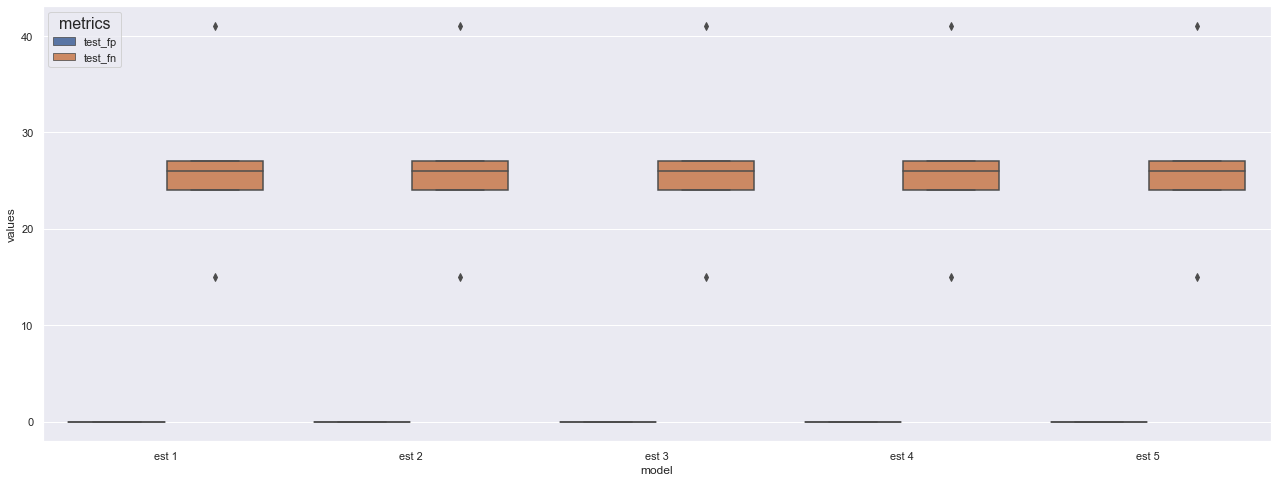

In [16]:
fig = plot_metrics(extract_metrics(results, ['test_fn', 'test_fp']))

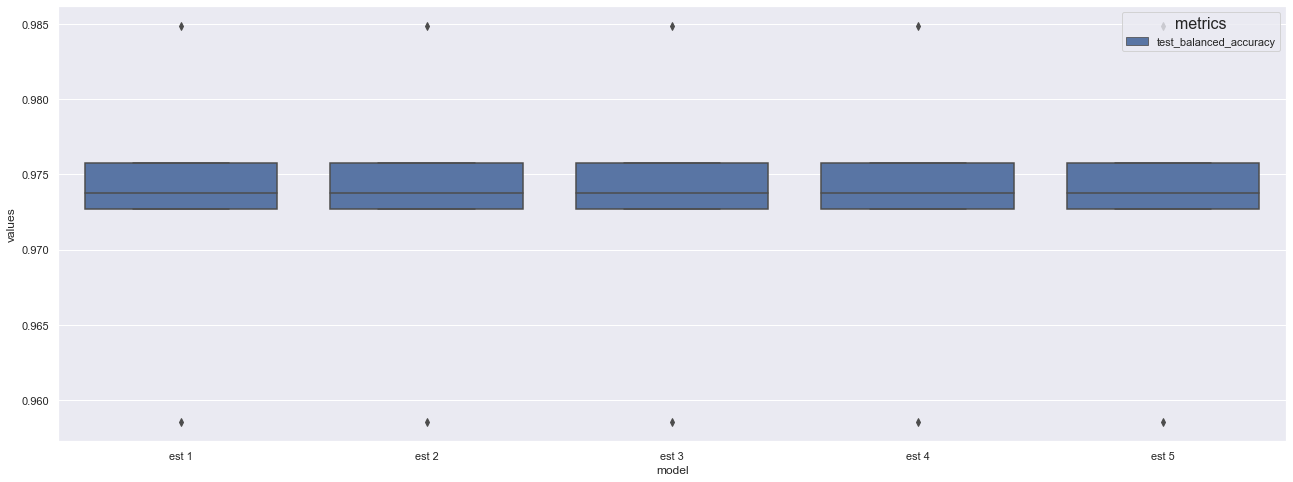

In [22]:
fig = plot_metrics(extract_metrics(results, ['test_balanced_accuracy']))

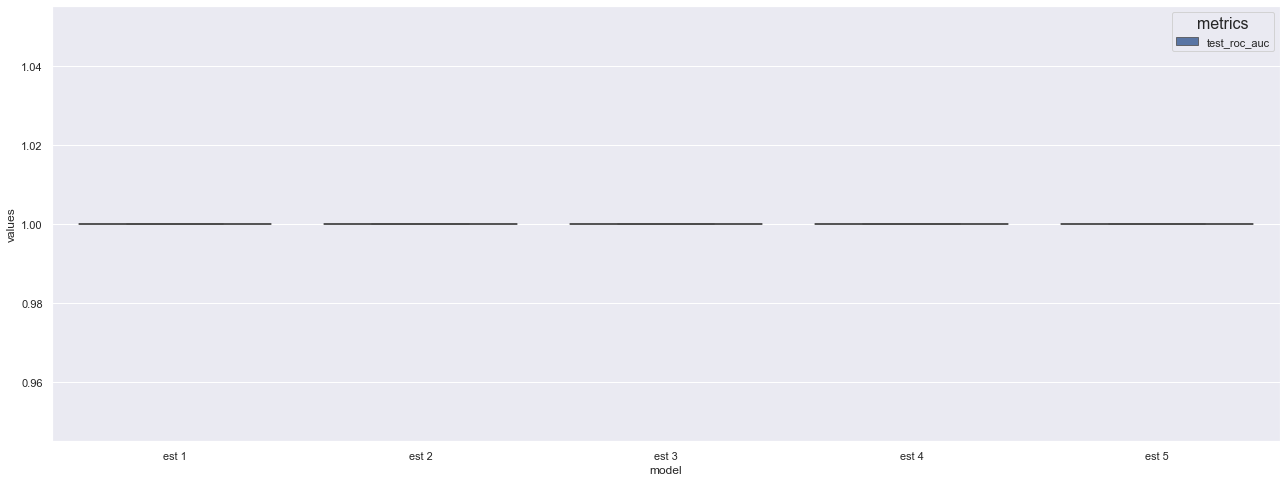

In [18]:
fig = plot_metrics(extract_metrics(results, ['test_roc_auc']))

In [ ]:
assert False

In [ ]:

estimator = OneClassSVM(gamma='scale', nu=0.02)
#scaler = StandardScaler()

pipelines = [
        ('no scaling', Pipeline([('est', estimator)])),
        ('StandardScaler', Pipeline([('scaler', StandardScaler()), ('est', estimator)])),
        ('RobustScaler', Pipeline([('scaler', RobustScaler()), ('est', estimator)])),
    ]

In [ ]:

models = [
    ('Isolation Forest', IsolationForest(contamination=0.08, n_estimators=500)),
    ('MCD', EllipticEnvelope(contamination=0.02)),
    ('SVM', OneClassSVM(gamma='scale', nu=0.02)),
        ]

In [ ]:
results = classification_benchmark(X=X, y=y,
                         models=models,
                         cv=cv,
                         scoring=scoring,
                         random_state=random_state)

In [ ]:
fig = plot_metrics(extract_metrics(results, ['test_tp', 'test_fp']))

In [ ]:
from sklearn import model_selection


# IMPORTANT! if you get an error like this, the generator is exhausted, and it doesn't reset on its own.
# This causes the list of scored results to be empty, hence the error.
'''
File ~\Anaconda3\envs\py39fullstack\lib\site-packages\sklearn\model_selection\_validation.py:1884, in _aggregate_score_dicts(scores)
   1857 def _aggregate_score_dicts(scores):
   1858     """Aggregate the list of dict to dict of np ndarray
   1859 
   1860     The aggregated output of _aggregate_score_dicts will be a list of dict
   (...)
   1878      'b': array([10, 2, 3, 10])}
   1879     """
   1880     return {
   1881         key: np.asarray([score[key] for score in scores])
   1882         if isinstance(scores[0][key], numbers.Number)
   1883         else [score[key] for score in scores]
-> 1884         for key in scores[0]
   1885     }

IndexError: list index out of range
'''
cv_results = model_selection.cross_validate(model, X, y,
                                                        cv=cv, groups=None,
                                                        scoring=scoring,
                                                        n_jobs=4)

cv_results

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


def print_report(testy, svm_yhat, target_names=['anomaly', 'pristine']):
#def print_report(testy, svm_yhat, target_names=None):
        print('-----------------------------------------------------')
        print(classification_report(testy, svm_yhat, target_names=target_names))


def evaluate_model(X_train, X_test, y_test, model, model_description):
    model.fit(X_train)

    # detect anomalies
    y_hat = model.predict(X_test)

    # dump evaluation metrics
    score = f1_score(y_test, y_hat, pos_label=-1)
    print('#####################################################')
    print(model_description + ' f-measure: %.3f' % score)
    print_report(y_test, y_hat)
    print('#####################################################')
        
        
        
def experiment(X, y, models):
    # split into train/test sets
    seed = np.random.randint(np.iinfo(np.dtype('uint16')).max)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
    
    # just keep pristine samples for training
    X_train = X_train[y_train==1]    

    for name, model in models:
        evaluate_model(X_train, X_test, y_test, model, name)
        

In [ ]:
def plot_perf_metrics(perf_metrics, file_name=None, rotation=45, ylim=None):
    '''
    '''
    plt.figure()
    
    sns.set(font_scale=2.5)
    fig = sns.boxplot(x="model", y="values", hue="metrics", data=perf_metrics)
    plt.legend(loc='best', borderaxespad=0.5)
    plt.title('Metrics')
    fig.set_xticklabels(fig.get_xticklabels(), rotation=rotation)
    
    if(ylim is not None):
        plt.ylim(ylim)

    plt.show()
    plt.draw()
    
    return fig


In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn import datasets

from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.svm import SVC, NuSVC
from xgboost import XGBClassifier

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor


def get_classifier_experiment(random_state=None):
    estimators = [
        ('Isolation Forest', IsolationForest(contamination=0.08, n_estimators=500)),
        ('MCD', EllipticEnvelope(contamination=0.02)),
        ('SVM', OneClassSVM(gamma='scale', nu=0.02)),
#        ('Dummy_strat', DummyClassifier(strategy="stratified")),
#        ('Dummy_mode', DummyClassifier(strategy="most_frequent")),
#        ('LogReg', LogisticRegression(random_state=random_state)),
#        ('DecisionTree', DecisionTreeClassifier(random_state=random_state)),
#        ('RandomForest', RandomForestClassifier(random_state=random_state)),
#        ('XGB', XGBClassifier(random_state=random_state)),
#        ('KNN', KNeighborsClassifier()), # has no random_state parameter
#        ('AdaBoost', AdaBoostClassifier(random_state=random_state)),
#        ('GNB', GaussianNB()),
#        ('GNB_scaled', Pipeline([('scaler', QuantileTransformer(output_distribution='normal')),
#                     ('est', GaussianNB())])),
        
#        ('GP', GaussianProcessClassifier(kernel=1.0*RBF(1.0), random_state=random_state)),
#        ('GBM', GradientBoostingClassifier(random_state=random_state)),
#        ('QDA', QuadraticDiscriminantAnalysis()),
#        ('QDA_scaled', Pipeline([('scaler', QuantileTransformer(output_distribution='normal')),
#                     ('est', QuadraticDiscriminantAnalysis())])),
#        ('MLP', MLPClassifier(alpha=1, max_iter=1000, random_state=random_state)),
#        ('MLP_scaled', Pipeline([('scaler', QuantileTransformer(output_distribution='normal')),
#                     ('est', MLPClassifier(alpha=1, max_iter=1000, random_state=random_state))])),
#        ('SVM linear', SVC(kernel='linear', random_state=random_state)),
#        ('SVM lin_scaled', Pipeline([('scaler', QuantileTransformer(output_distribution='normal')),
#                     ('est', SVC(kernel='linear', random_state=random_state))])),
#        ('SVM sigm', SVC(kernel='sigmoid', random_state=random_state)),
#        ('SVM poly', SVC(kernel='poly', random_state=random_state)),
#        ('SVM rbf', SVC(kernel='rbf', random_state=random_state)),
    ]
    
    return estimators


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

estimator = OneClassSVM(gamma='scale', nu=0.02)
#scaler = StandardScaler()

pipelines = [
        ('no scaling', Pipeline([('est', estimator)])),
        ('StandardScaler', Pipeline([('scaler', StandardScaler()), ('est', estimator)])),
        ('RobustScaler', Pipeline([('scaler', RobustScaler()), ('est', estimator)])),
    ]

In [ ]:
name, model = pipelines[1]

In [ ]:
name

In [ ]:
model

In [ ]:
cv_results = model_selection.cross_validate(model, X, y,
                                                        cv=cv, groups=None,
                                                        scoring=None,
                                                        n_jobs=4)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, KFold

#cv = StratifiedKFold(n_splits=3, random_state=random_state)
cv = StratifiedShuffleSplit(n_splits=8, test_size=0.1,
                                    random_state=random_state)
#cv = KFold(n_splits=2)

train_splits = []
test_splits = []

for train_idx, test_idx in cv.split(X, y):
    #print("%s %s" % (train, test))
    #todo: remove indices of 'D'
    print("train")
    cnt = Counter(y[train_idx])
    print(cnt)

    
    print("\ntrain modified")
    mask = np.ones(len(train_idx), dtype=bool)
    print(train_idx.shape)
    print(mask.shape)
    mask[y[train_idx]=='D'] = False
    #cnt = Counter(y[train_idx][mask])
    #print(cnt)
    #cv.append([0,1,2,3])
    
    train_splits.append(train_idx[mask])
    
    
    print("\ntest")
    cnt = Counter(y[test_idx])
    print(cnt)
    
    test_splits.append(test_idx)
    
    
anomaly_cv = zip(train_splits, test_splits)    

In [ ]:
for train_idx, test_idx in zip(train_splits, test_splits):
    #print("%s %s" % (train, test))
    #todo: remove indices of 'D'
    print("train")
    cnt = Counter(y[train_idx])
    print(cnt)
    
    print(np.max(train_idx))
    print(np.max(test_idx))


In [ ]:
cv = anomaly_cv

#X, y, models, cv=None
cv_results = classification_benchmark(X=X, y=y_num, models=pipelines, cv=cv)

In [ ]:
result = extract_metrics(cv_results, ['test_balanced_accuracy'])



#from plot_utils import plot_perf_metrics
fig = plot_perf_metrics(result)